In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from lenet.nn.conv import LeNet
from imutils import paths
import imutils
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

Using TensorFlow backend.
C:\Users\Yahia.Kala\Anaconda3\envs\stream1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Yahia.Kala\Anaconda3\envs\stream1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Yahia.Kala\Anaconda3\envs\stream1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Yahia.Kala\Anacon

In [22]:
import pandas as pd

In [2]:
args = {}
args['dataset'] = './SMILEs'
args['model'] = './model3.h5'

In [3]:
# initialize the list of data and labels
data = []
labels = []

# loop over the input images
for imagePath in sorted(list(paths.list_images(args['dataset']))):
    # load the image, pre-process it, and store in the data list
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = imutils.resize(image, width=28) # 28 x 28 x 1
    image = img_to_array(image)
    data.append(image)

    # extravt the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-3] # C:\Users\Balaji\Documents\Smile-Detector\SMILEs\positives\positives7\3.jpg
    label = 'smiling' if label == 'positives' else 'not_smiling'
    labels.append(label)

In [4]:
len(data), len(labels)

(13165, 13165)

In [5]:
np.shape(data[0])

(28, 28, 1)

In [6]:
labels[0:3]

['not_smiling', 'not_smiling', 'not_smiling']

In [7]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype='float') / 255.0 # 0 to 255
labels = np.array(labels)

In [8]:
# convert the labels from integers to vectors
le = LabelEncoder().fit(labels)
labels = np_utils.to_categorical(le.transform(labels), 2)

In [9]:
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = dict()


for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]

In [10]:
# partition the data into training and testing sploits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels,
                                                  test_size=0.20,
                                                  stratify=labels,
                                                  random_state=42)


In [11]:

# initialize the model
print('[INFO] compiling model...')
model = LeNet.build(width=28, height=28, depth=1, classes=2)
model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy'])

[INFO] compiling model...



In [12]:
# train the network
print('[INFO] training network...')
H = model.fit(trainX, trainY, validation_data=(testX, testY),
              class_weight=classWeight, batch_size=64, epochs=15, verbose=1)


[INFO] training network...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 10532 samples, validate on 2633 samples
Epoch 1/15
10532/10532 [==============================] - 12s 1ms/step - loss: 0.6484 - accuracy: 0.7856 - val_loss: 0.3798 - val_accuracy: 0.8333
Epoch 2/15
10532/10532 [==============================] - 12s 1ms/step - loss: 0.4419 - accuracy: 0.8765 - val_loss: 0.3195 - val_accuracy: 0.8618
Epoch 3/15
10532/10532 [==============================] - 15s 1ms/step - loss: 0.3976 - accuracy: 0.8895 - val_loss: 0.3348 - val_accuracy: 0.8580
Epoch 4/15
10532/10532 [==============================] - 12s 1ms/step - loss: 0.3852 - accuracy: 0.8927 - val_loss: 0.2547 - val_accuracy: 0.9020
Epoch 5/15
10532/10532 [==============================] - 11s 1ms/step - loss: 0.3516 - accuracy: 0.9040 - val_loss: 0.3072 - val_accuracy: 0.8724
Epoch 6/15
10532/10532 [==============================] - 11s 1ms/step - loss: 0.3386 - accura

In [13]:
# evaluate the network
print('[INFO] evaluating network...')
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=le.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

 not_smiling       0.95      0.89      0.92      1895
     smiling       0.76      0.89      0.82       738

    accuracy                           0.89      2633
   macro avg       0.86      0.89      0.87      2633
weighted avg       0.90      0.89      0.89      2633



In [14]:
# save the model to disk
print('[INFO] serializing network')
model.save(args['model'])

[INFO] serializing network


In [15]:
# model.save('./model3.h5')

In [36]:
fitresult = pd.DataFrame(H.history)
fitresult.to_csv('fitresult.csv', index=False)

In [30]:
# pd.read_csv('fitresult.csv')

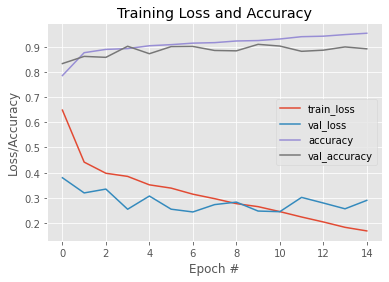

In [26]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, 15), fitresult['loss'], label='train_loss')
plt.plot(np.arange(0, 15), fitresult['val_loss'], label='val_loss')
plt.plot(np.arange(0, 15), fitresult['accuracy'], label='accuracy')
plt.plot(np.arange(0, 15), fitresult['val_accuracy'], label='val_accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [33]:
import altair as alt

In [50]:
fitresult['epoch'] = np.arange(0, 15)
fitresult2 = pd.melt(fitresult, id_vars=['epoch'], var_name='series', value_name='loss')

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['epoch'], empty='none')

# The basic line
line = alt.Chart(fitresult2).mark_line(interpolate='basis').encode(
    x='epoch:Q',
    y='loss:Q',
    color='series:N'
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(fitresult2).mark_point().encode(
    x='epoch:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)
# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'loss:Q', alt.value(' '), format='.3f')
)
# Draw a rule at the location of the selection
rules = alt.Chart(fitresult2).mark_rule(color='gray').encode(
    x='epoch:Q',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text
).properties(
    width=600, height=300
)
# alt.Chart(fitresult2).mark_line().encode(
#     x='epoch',
#     y='loss',
#     color='series',
#     tooltip=['epoch']
# )

alt.LayerChart(...)